In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import keras
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
#deifining empty data and label lists
data_1 = []
labels_1 = []

In [0]:
#importing and processing the infected cell images
parasitized = "/content/cell_images/Parasitized/"
for filename in os.listdir(parasitized):
    img = cv2.imread(parasitized+filename)     # Read image as an array
    if img is not None:
        img_arr = Image.fromarray(img , 'RGB') #Converting image from array to an RGB image.
        re_img = img_arr.resize((64 , 64))     #Resizing image
        data_1.append(np.array(re_img))          #appending image after converting it back to array
        labels_1.append(to_categorical(1, num_classes=2))

In [0]:
#importing and processing the infected cell images
uninfected = "/content/cell_images/Uninfected/"
for filename in os.listdir(uninfected):
    img = cv2.imread(uninfected+filename)
    if img is not None:
        img_arr = Image.fromarray(img , 'RGB')
        re_img = img_arr.resize((64 , 64))
        data_1.append(np.array(re_img))
        labels_1.append(to_categorical(0, num_classes=2))

In [0]:
#Converting data and labels to numpy array
data = np.array(data_1)
labels = np.array(labels_1)

In [8]:
data.shape

(27558, 64, 64, 3)

In [9]:
labels.shape

(27558, 2)

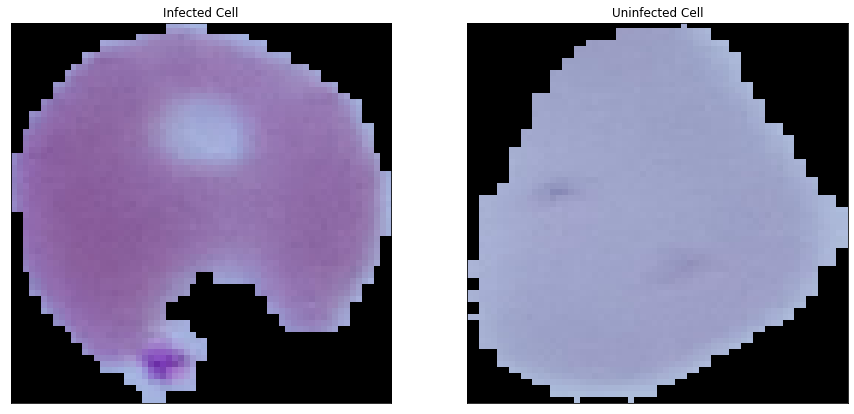

In [10]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(data[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(data[16000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

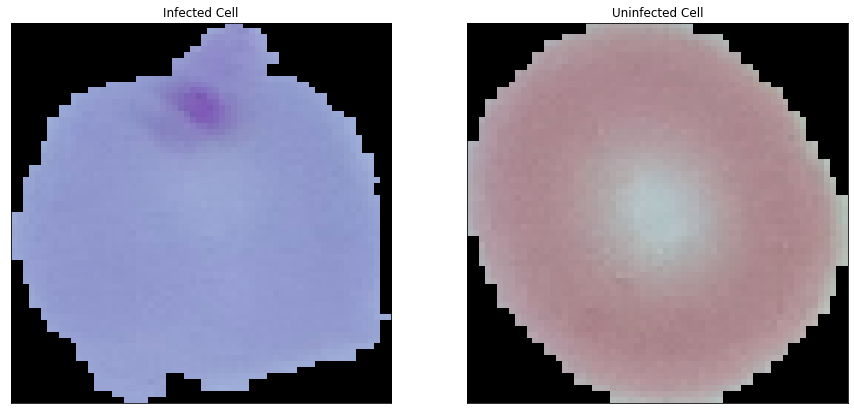

In [11]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(data[1])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(data[15999])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [12]:
data.shape[0]

27558

In [0]:
#Initializing a random sequence of number which is the same length as of data
n = np.arange(data.shape[0])
np.random.shuffle(n)

In [14]:
n

array([ 6770, 18346,  3407, ..., 23539, 26534,  9660])

In [0]:
data = data[n]
labels = labels[n]

In [0]:
data = data[:5000]
labels = labels[:5000]

In [17]:
labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [0]:
#Changing data type to float
data = data.astype(np.float32)
labels = labels.astype(np.int32)

In [0]:
#Scaling the data
data = data/255

In [0]:
#Splitting the data into train and eval
from sklearn.model_selection import train_test_split

train_x , eval_x , train_y , eval_y = train_test_split(data , labels , 
                                            test_size = 0.3 ,
                                            random_state = 111)

In [0]:
#Splitting data into test and validation
val_x , test_x , val_y , test_y = train_test_split(eval_x, eval_y , 
                                            test_size = 0.5 ,
                                            random_state = 111)

In [22]:
print('train data shape {} ,val data shape {} '.format(train_x.shape, val_x.shape))

train data shape (3500, 64, 64, 3) ,val data shape (750, 64, 64, 3) 


In [0]:
# Generating augmented images

from keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    vertical_flip=True)  

val_aug= ImageDataGenerator(
    rescale=1./255)

test_aug= ImageDataGenerator(
    rescale=1./255)

train_gen = train_aug.flow(
    train_x,
    train_y,
    batch_size=16)

val_gen = val_aug.flow(
    val_x,
    val_y,
    batch_size=16)

test_gen = test_aug.flow(
    test_x,
    test_y,
    batch_size=16)

In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [0]:
from keras.models import Sequential
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.layers import Dense,Flatten,Dropout,Lambda

In [26]:
#Defining model layers and parameters
def ConvBlock(model, layers, filters,name):
    for i in range(layers):
        model.add(Conv2D(filters, (3, 3), activation='relu',name=name))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(64, 64, 3)))
    ConvBlock(model, 1, 64,'block_1')
    ConvBlock(model, 1, 64,'block_2')
    ConvBlock(model, 1, 64,'block_3')
    #ConvBlock(model, 1, 64,'block_4')
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='sigmoid'))
    return model

model = FCN()
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
block_1 (Conv2D)             (None, 62, 62, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
block_2 (Conv2D)             (None, 29, 29, 64)        3692

In [0]:
# Defining Callbacks
best_model_weights = './base.model'

earlystop = EarlyStopping(       # Stop training when a monitored quantity has stopped improving.
    monitor='val_loss',
    min_delta=0.001,
    patience=7,
    verbose=2,
    mode='min')

checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1)

reducelr = ReduceLROnPlateau(    #Reduce learning rate when a metric has stopped improving
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 )

callbacks = [earlystop]

In [28]:
# Compiling model and fitting the data

model.compile(
    loss='binary_crossentropy',
    optimizer= 'adam',
    metrics=['accuracy']
)

history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 500, 
    validation_data  = val_gen,
    validation_steps = 200,
    epochs = 10,
    #max_queue_size=10,
    use_multiprocessing=True,
    workers=-1, 
    verbose = 1,
    callbacks=callbacks
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
500/500 [==============================] - 19s 39ms/step - loss: 0.6835 - acc: 0.6254 - val_loss: 0.7264 - val_acc: 0.5962
Epoch 2/10
500/500 [==============================] - 12s 25ms/step - loss: 0.3742 - acc: 0.8406 - val_loss: 0.3033 - val_acc: 0.8728
Epoch 3/10
500/500 [==============================] - 12s 24ms/step - loss: 0.2200 - acc: 0.9257 - val_loss: 0.2012 - val_acc: 0.9228
Epoch 4/10
500/500 [==============================] - 12s 24ms/step - loss: 0.2038 - acc: 0.9279 - val_loss: 0.1834 - val_acc: 0.9459
Epoch 5/10
500/500 [==============================] - 12s 25ms/step - loss: 0.1840 - acc: 0.9359 - val_loss: 0.2736 - val_acc: 0.8935
Epoch 6/10
500/500 [==============================] - 12s 25ms/step - loss: 0.1768 - acc: 0.9404 - val_loss: 0.1590 - val_acc: 0.9524
Epoch 7/10
500/500 [==============================] - 12s 25ms/step - loss: 0.1669 - acc: 0.9438 -

In [29]:
model_score = model.evaluate(x=test_x, y=test_y)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

750/750 [==============================] - 0s 170us/step
Model Test Loss: 7.844130448659261
Model Test Accuracy: 0.5106666669845581


In [30]:
model_score = model.evaluate_generator(test_gen,steps=50)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

Model Test Loss: 0.23250934122162953
Model Test Accuracy: 0.9279448617072332


In [31]:
model_score = model.evaluate_generator(val_gen,steps=50)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

Model Test Loss: 0.22961161267899333
Model Test Accuracy: 0.9191729324802121


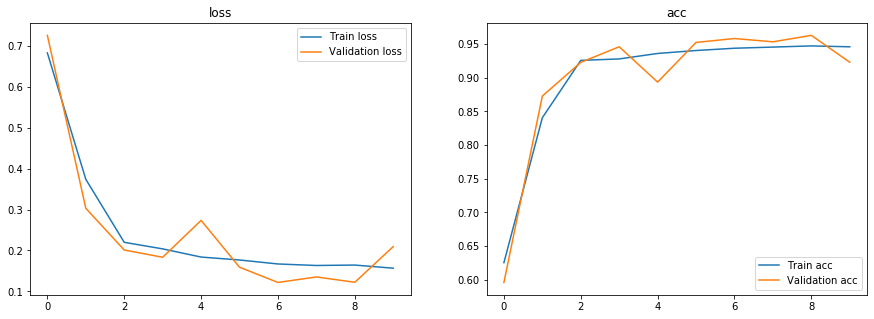

In [32]:
show_final_history(history)

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict(test_x)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_y,axis = 1)

CM = confusion_matrix(y_true, pred)
print("Confusion Matrix")
print(CM)
print("--")
print("--")
print("Classification Report")
print(classification_report(y_true, pred))

Confusion Matrix
[[383   0]
 [367   0]]
--
--
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       383
           1       0.00      0.00      0.00       367

    accuracy                           0.51       750
   macro avg       0.26      0.50      0.34       750
weighted avg       0.26      0.51      0.35       750

